In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/FLIC')

In [3]:
!ls -la
!ls src/
!ls data/ | head -5

total 16
drwx------ 2 root root 4096 Dec 12 14:53 data
drwx------ 2 root root 4096 Dec 16 12:03 models
drwx------ 2 root root 4096 Dec 16 12:03 notebooks
drwx------ 2 root root 4096 Dec 20 17:28 src
dataset.py   __init__.py  __pycache__  utils.py
evaluate.py  models.py	  train.py
calcite
pyrite
quartz
rocks
superficies_texturizadas


In [4]:
!pip install -q torch torchvision matplotlib seaborn scikit-learn Pillow

In [5]:
import sys
sys.path.append('.')

import torch
import matplotlib.pyplot as plt
import random

from src.dataset import get_dataloaders
from src.models import CustomCNN, get_resnet18
from src.train import train_model
from src.evaluate import evaluate_model, plot_confusion_matrix, plot_training_history
from src.utils import predict_from_dataset, visualize_prediction_from_dataset, visualize_dataset_samples

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
if DEVICE.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [6]:
# Carga de datos geológicos
DATA_DIR = 'data'
BATCH_SIZE = 64

train_loader, val_loader, test_loader, class_names = get_dataloaders(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    val_split=0.15,
    test_split=0.15
)

print(f"Clases: {len(class_names)}")
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Clases: 5
Training samples: 13902
Validation samples: 2979
Test samples: 2979


In [7]:
# Clases del dataset
print("Clases geológicas:")
for i, class_name in enumerate(class_names, 1):
    print(f"{i}. {class_name}")

Clases geológicas:
1. calcite
2. pyrite
3. quartz
4. rocks
5. superficies_texturizadas


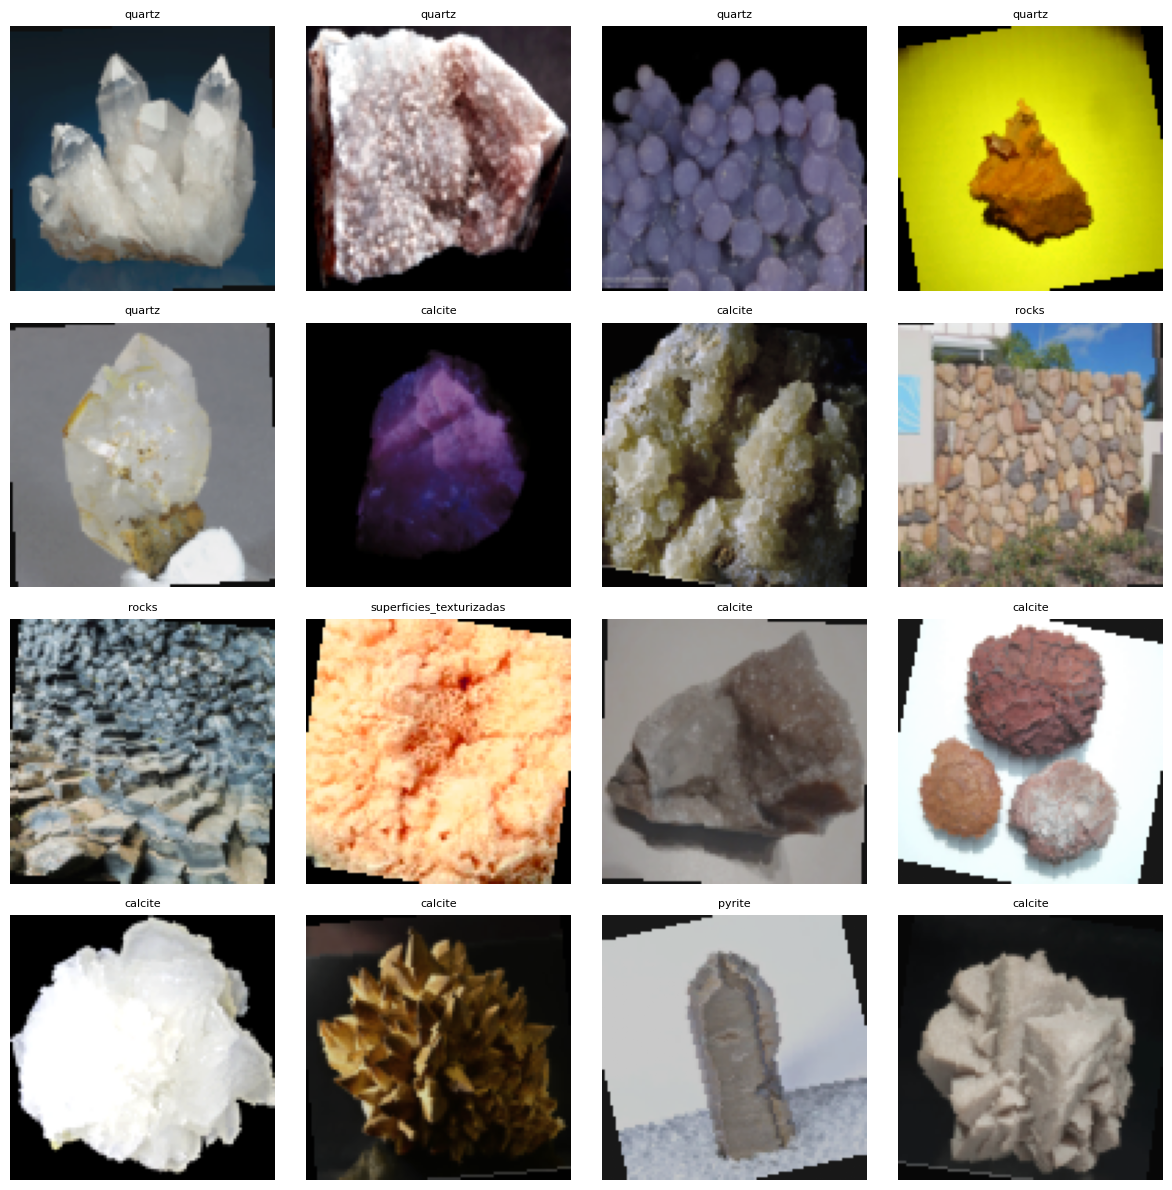

In [8]:
# Muestra aleatoria de imágenes del dataset
visualize_dataset_samples(train_loader.dataset.dataset, class_names, n_samples=16)

In [9]:
# Entrenar o cargar CustomCNN
import os

MODEL_PATH_CNN = 'models/custom_cnn.pth'
os.makedirs('models', exist_ok=True)

if os.path.exists(MODEL_PATH_CNN):
    print("CUSTOM CNN - CARGANDO MODELO GUARDADO")
    model_cnn = CustomCNN(num_classes=len(class_names))
    model_cnn.load_state_dict(torch.load(MODEL_PATH_CNN))
    model_cnn = model_cnn.to(DEVICE)
    print(f"Modelo cargado desde: {MODEL_PATH_CNN}")
    print("Saltando entrenamiento...")
    history_cnn = None  # No hay historial si se carga
else:
    print("ENTRENAMIENTO CUSTOM CNN")
    print("Configuración óptima: 30 epochs, lr=0.001, weight_decay=1e-4")

    model_cnn = CustomCNN(num_classes=len(class_names))

    history_cnn = train_model(
        model_cnn,
        train_loader,
        val_loader,
        epochs=30,
        lr=0.001,
        weight_decay=1e-4,
        device=DEVICE
    )

    # Guardar modelo entrenado
    torch.save(model_cnn.state_dict(), MODEL_PATH_CNN)
    print(f"\n✓ Modelo guardado en: {MODEL_PATH_CNN}")

    print(f"\nResultados CustomCNN:")
    print(f"  Train Accuracy: {history_cnn['train_acc'][-1]:.2f}%")
    print(f"  Val Accuracy: {history_cnn['val_acc'][-1]:.2f}%")
    print(f"  Val Loss: {history_cnn['val_loss'][-1]:.4f}")

CUSTOM CNN - CARGANDO MODELO GUARDADO
Modelo cargado desde: models/custom_cnn.pth
Saltando entrenamiento...


In [10]:
# Visualización curvas de entrenamiento CustomCNN (solo si fue entrenado)
if history_cnn is not None:
    plot_training_history(history_cnn)
else:
    print("Modelo cargado de archivo, no hay historial de entrenamiento.")

Modelo cargado de archivo, no hay historial de entrenamiento.


In [11]:
import os

# Entrenar o cargar ResNet18
MODEL_PATH_RESNET = 'models/resnet18.pth'

if os.path.exists(MODEL_PATH_RESNET):
    print("RESNET18 - CARGANDO MODELO GUARDADO")
    model_resnet = get_resnet18(num_classes=len(class_names), pretrained=False, freeze_layers=False)
    model_resnet.load_state_dict(torch.load(MODEL_PATH_RESNET))
    model_resnet = model_resnet.to(DEVICE)
    print(f"Modelo cargado desde: {MODEL_PATH_RESNET}")
    print("Saltando entrenamiento...")
    history_resnet = None  # No hay historial si se carga
else:
    print("ENTRENAMIENTO RESNET18 (TRANSFER LEARNING)")
    print("Configuración óptima: 15 epochs, lr=0.0005, weight_decay=1e-4")

    model_resnet = get_resnet18(num_classes=len(class_names), pretrained=True, freeze_layers=True)

    history_resnet = train_model(
        model_resnet,
        train_loader,
        val_loader,
        epochs=15,
        lr=0.0005,
        weight_decay=1e-4,
        device=DEVICE
    )

    # Guardar modelo entrenado
    torch.save(model_resnet.state_dict(), MODEL_PATH_RESNET)
    print(f"\n✓ Modelo guardado en: {MODEL_PATH_RESNET}")

    print(f"\nResultados ResNet18:")
    print(f"  Train Accuracy: {history_resnet['train_acc'][-1]:.2f}%")
    print(f"  Val Accuracy: {history_resnet['val_acc'][-1]:.2f}%")
    print(f"  Val Loss: {history_resnet['val_loss'][-1]:.4f}")

RESNET18 - CARGANDO MODELO GUARDADO
Modelo cargado desde: models/resnet18.pth
Saltando entrenamiento...


In [12]:
# Visualización curvas de entrenamiento ResNet18 (solo si fue entrenado)
if history_resnet is not None:
    plot_training_history(history_resnet)
else:
    print("Modelo cargado de archivo, no hay historial de entrenamiento.")

Modelo cargado de archivo, no hay historial de entrenamiento.


In [13]:
# Evaluación Custom CNN en test set
print("EVALUACIÓN: CUSTOM CNN")
results_cnn = evaluate_model(model_cnn, test_loader, class_names, device=DEVICE)

EVALUACIÓN: CUSTOM CNN


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Accuracy: 62.40%

Classification Report:
                          precision    recall  f1-score   support

                 calcite       0.59      0.58      0.59       964
                  pyrite       0.67      0.63      0.65       372
                  quartz       0.64      0.64      0.64      1235
                   rocks       0.62      0.68      0.65       357
superficies_texturizadas       0.51      0.43      0.47        51

                accuracy                           0.62      2979
               macro avg       0.61      0.59      0.60      2979
            weighted avg       0.62      0.62      0.62      2979



In [14]:
# Evaluación ResNet18 en test set
print("EVALUACIÓN: RESNET18")
results_resnet = evaluate_model(model_resnet, test_loader, class_names, device=DEVICE)

EVALUACIÓN: RESNET18
Test Accuracy: 70.93%

Classification Report:
                          precision    recall  f1-score   support

                 calcite       0.68      0.65      0.67       964
                  pyrite       0.71      0.71      0.71       372
                  quartz       0.72      0.73      0.73      1235
                   rocks       0.75      0.78      0.76       357
superficies_texturizadas       0.88      0.69      0.77        51

                accuracy                           0.71      2979
               macro avg       0.75      0.71      0.73      2979
            weighted avg       0.71      0.71      0.71      2979



In [15]:
# Comparación final en test set
print("COMPARACIÓN FINAL - TEST SET")
print(f"Custom CNN: {results_cnn['accuracy']:.2f}%")
print(f"ResNet18: {results_resnet['accuracy']:.2f}%")
print(f"\nMejora con Transfer Learning: {results_resnet['accuracy'] - results_cnn['accuracy']:.2f}%")

COMPARACIÓN FINAL - TEST SET
Custom CNN: 62.40%
ResNet18: 70.93%

Mejora con Transfer Learning: 8.53%


Matriz de Confusión - Custom CNN


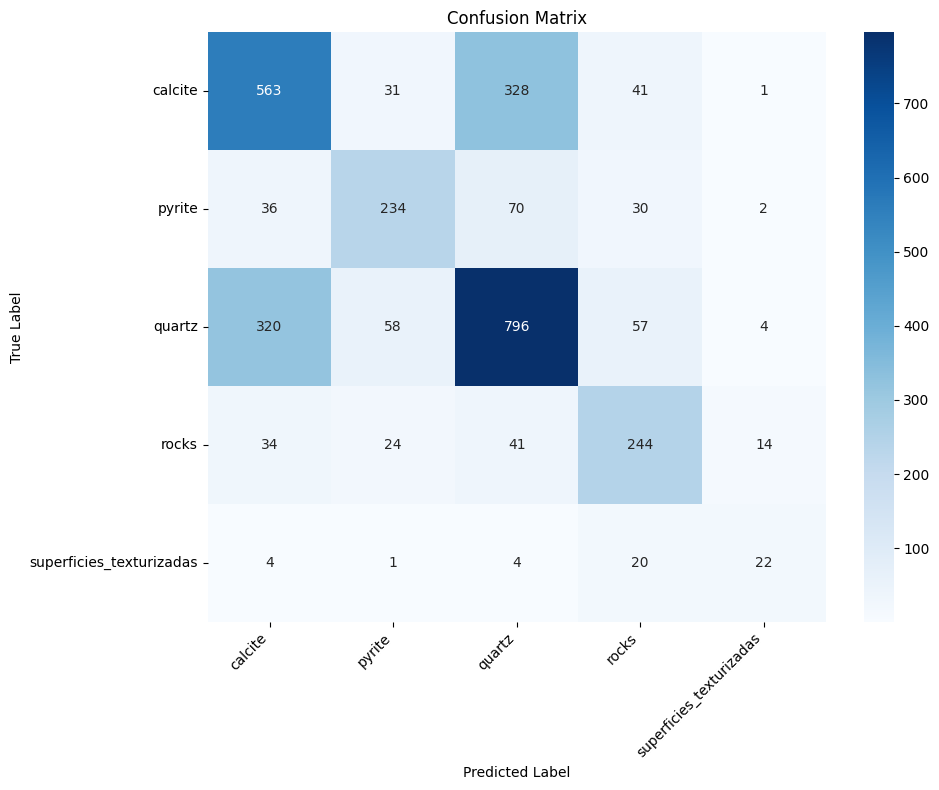

In [16]:
# Matriz de confusión CustomCNN
print("Matriz de Confusión - Custom CNN")
plot_confusion_matrix(
    results_cnn['labels'],
    results_cnn['predictions'],
    class_names,
    figsize=(10, 8)
)

Matriz de Confusión - ResNet18


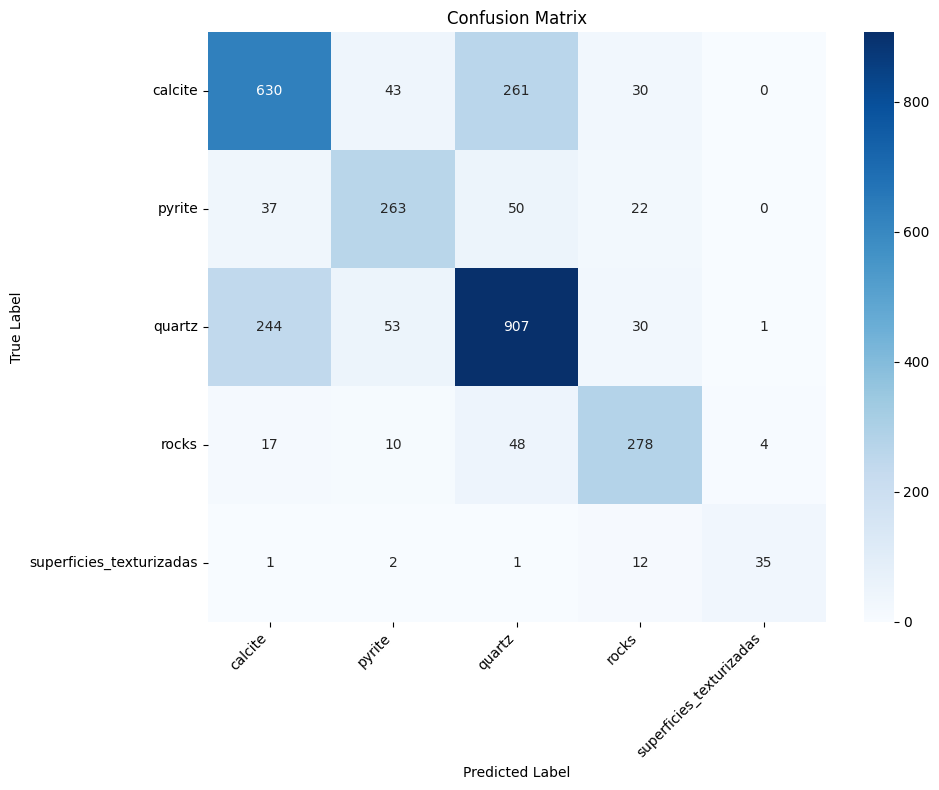

In [17]:
# Matriz de confusión ResNet18
print("Matriz de Confusión - ResNet18")
plot_confusion_matrix(
    results_resnet['labels'],
    results_resnet['predictions'],
    class_names,
    figsize=(10, 8)
)

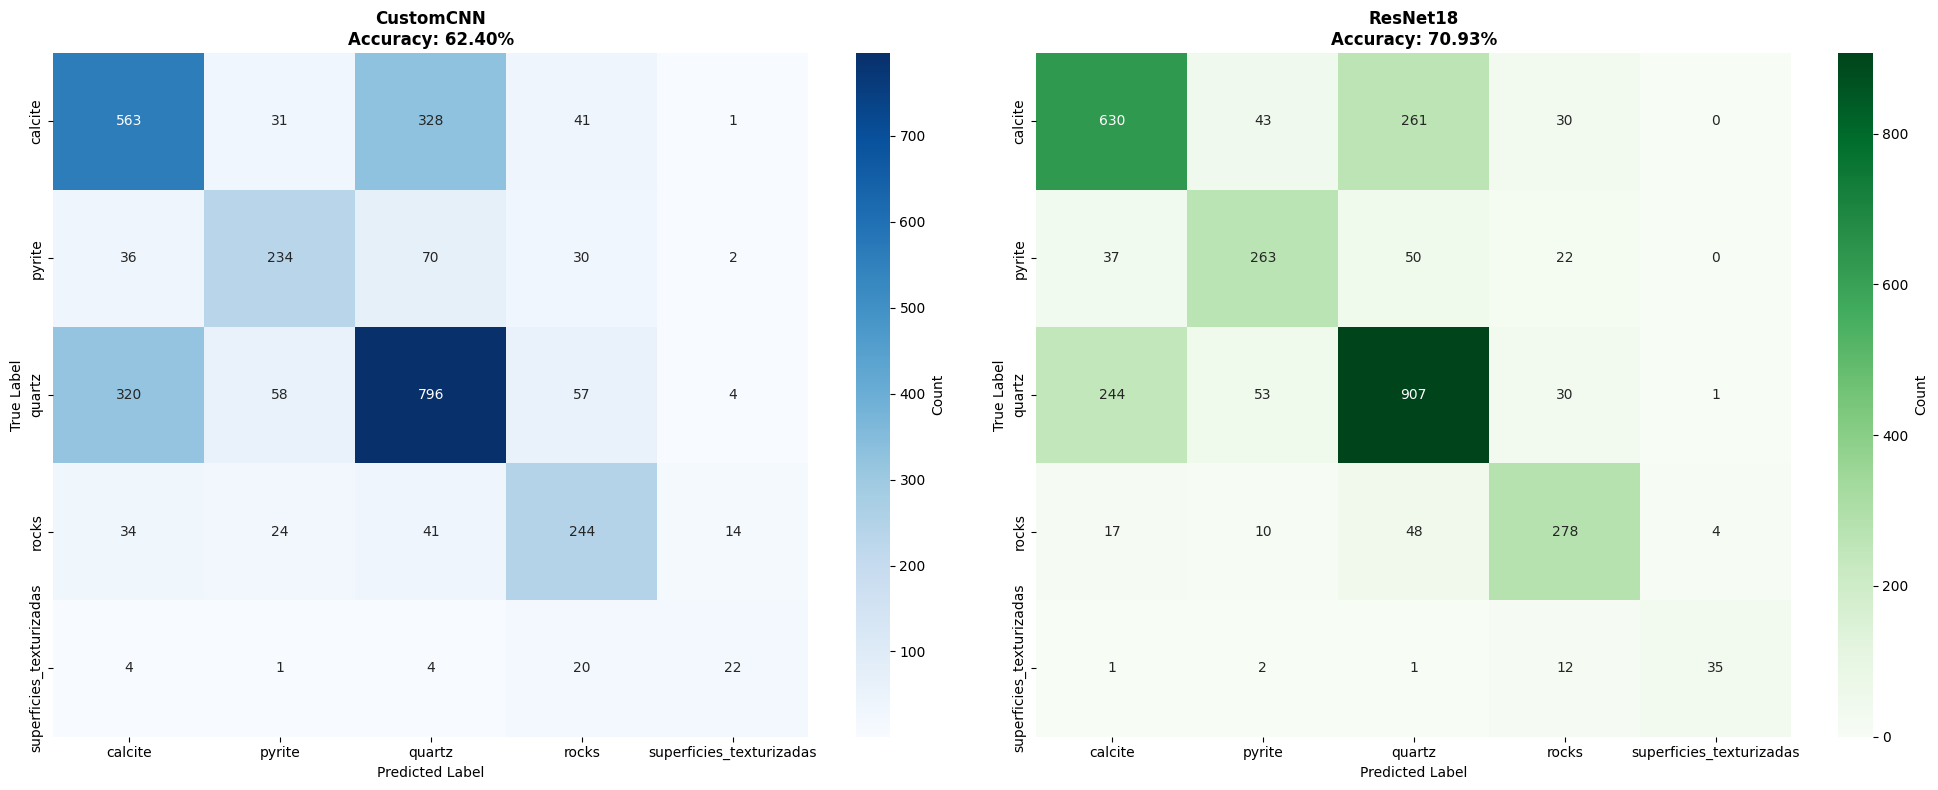

In [18]:
# Matrices de confusión de ambos modelos
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# CustomCNN
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_cnn = confusion_matrix(results_cnn['labels'], results_cnn['predictions'])
ax1 = axes[0]
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
            yticklabels=class_names, ax=ax1, cbar_kws={'label': 'Count'})
ax1.set_title(f'CustomCNN\nAccuracy: {results_cnn["accuracy"]:.2f}%',
              fontsize=12, fontweight='bold')
ax1.set_ylabel('True Label', fontsize=10)
ax1.set_xlabel('Predicted Label', fontsize=10)

# ResNet18
cm_resnet = confusion_matrix(results_resnet['labels'], results_resnet['predictions'])
ax2 = axes[1]
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Greens', xticklabels=class_names,
            yticklabels=class_names, ax=ax2, cbar_kws={'label': 'Count'})
ax2.set_title(f'ResNet18\nAccuracy: {results_resnet["accuracy"]:.2f}%',
              fontsize=12, fontweight='bold')
ax2.set_ylabel('True Label', fontsize=10)
ax2.set_xlabel('Predicted Label', fontsize=10)

plt.tight_layout()
plt.show()

PREDICCIÓN CUSTOM CNN
True Label: quartz

Top 5 predictions:
1. pyrite: 85.73%
2. rocks: 7.28%
3. quartz: 5.41%
4. calcite: 1.17%
5. superficies_texturizadas: 0.41%


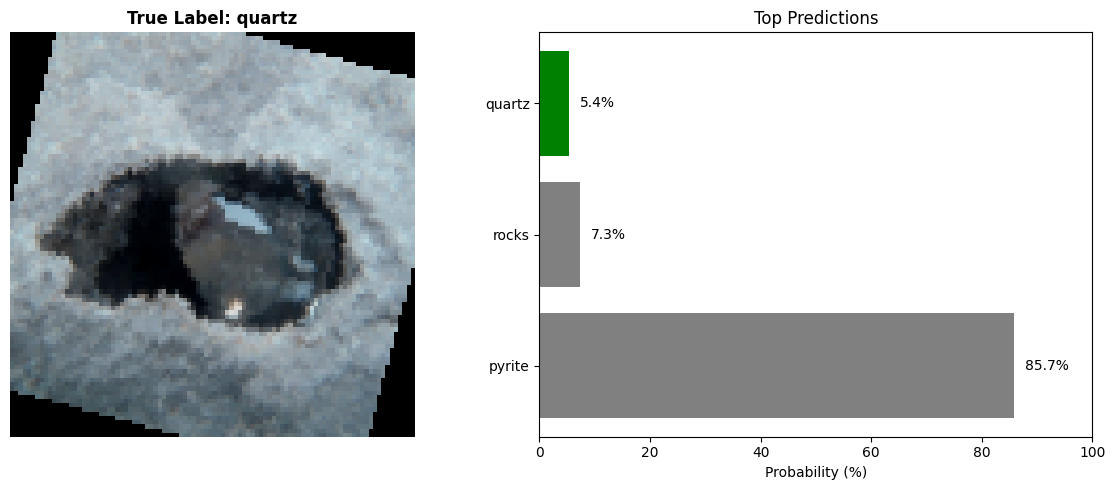

In [19]:
# Predicción con CustomCNN en imagen aleatoria del test set
test_dataset = test_loader.dataset.dataset
random_idx = random.randint(0, len(test_dataset) - 1)

predictions_cnn, true_label, image = predict_from_dataset(
    test_dataset,
    model_cnn,
    class_names,
    random_idx,
    device=DEVICE,
    top_k=5
)

print("PREDICCIÓN CUSTOM CNN")
print(f"True Label: {true_label}")
print("\nTop 5 predictions:")
for i, (class_name, prob) in enumerate(predictions_cnn, 1):
    print(f"{i}. {class_name}: {prob:.2f}%")

visualize_prediction_from_dataset(image, predictions_cnn[:3], true_label)

PREDICCIÓN RESNET18
True Label: quartz

Top 5 predictions:
1. quartz: 99.97%
2. rocks: 0.03%
3. pyrite: 0.00%
4. calcite: 0.00%
5. superficies_texturizadas: 0.00%


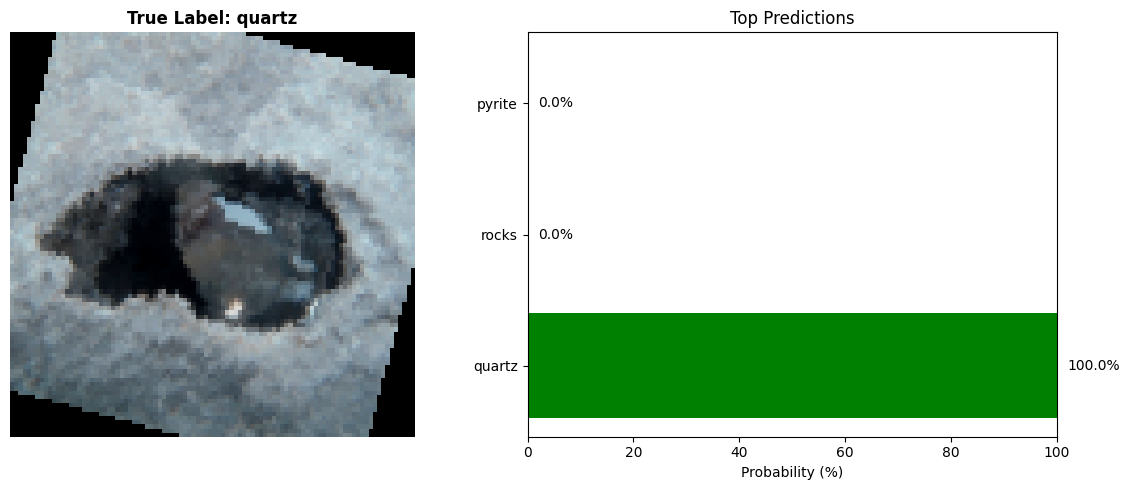

In [20]:
# Predicción con ResNet18 en la misma imagen
predictions_resnet, _, _ = predict_from_dataset(
    test_dataset,
    model_resnet,
    class_names,
    random_idx,
    device=DEVICE,
    top_k=5
)

print("PREDICCIÓN RESNET18")
print(f"True Label: {true_label}")
print("\nTop 5 predictions:")
for i, (class_name, prob) in enumerate(predictions_resnet, 1):
    print(f"{i}. {class_name}: {prob:.2f}%")

visualize_prediction_from_dataset(image, predictions_resnet[:3], true_label)

In [ ]:
# Predicciones: una imagen de cada clase con ambos modelos
import numpy as np

print("PREDICCIONES - UNA IMAGEN POR CLASE CON AMBOS MODELOS")

# MOVER MODELOS AL DEVICE UNA SOLA VEZ
model_cnn.to(DEVICE)
model_cnn.eval()
model_resnet.to(DEVICE)
model_resnet.eval()

test_dataset = test_loader.dataset.dataset

# Buscar índices de una imagen de cada clase
class_indices = {}
for idx in range(len(test_dataset)):
    _, label = test_dataset[idx]
    class_name = class_names[label]
    if class_name not in class_indices:
        class_indices[class_name] = idx
    if len(class_indices) == len(class_names):
        break

# Realizar predicciones con ambos modelos para cada clase
all_predictions = []
for class_name in class_names:
    idx = class_indices[class_name]

    # Predicciones CustomCNN
    pred_cnn, true_label, image = predict_from_dataset(
        test_dataset, model_cnn, class_names, idx, device=DEVICE, top_k=3
    )

    # Predicciones ResNet18
    pred_resnet, _, _ = predict_from_dataset(
        test_dataset, model_resnet, class_names, idx, device=DEVICE, top_k=3
    )

    all_predictions.append((class_name, pred_cnn, pred_resnet, true_label, image))

    print(f"\n{class_name.upper()}")
    print(f"  True Label: {true_label}")
    print(f"\n  CustomCNN:")
    for i, (pred_class, prob) in enumerate(pred_cnn, 1):
        marker = "✓" if pred_class == true_label else "✗"
        print(f"    {i}. {pred_class}: {prob:.2f}% {marker}")
    print(f"\n  ResNet18:")
    for i, (pred_class, prob) in enumerate(pred_resnet, 1):
        marker = "✓" if pred_class == true_label else "✗"
        print(f"    {i}. {pred_class}: {prob:.2f}% {marker}")

PREDICCIONES - UNA IMAGEN POR CLASE CON AMBOS MODELOS


In [ ]:
# Visualización comparativa: CustomCNN vs ResNet18 para las 5 clases
fig, axes = plt.subplots(5, 3, figsize=(18, 20))

for idx, (class_name, pred_cnn, pred_resnet, true_label, image_tensor) in enumerate(all_predictions):
    # Denormalizar imagen
    image = image_tensor.permute(1, 2, 0)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    image = image * std + mean
    image = torch.clamp(image, 0, 1)

    # Columna 1: Imagen
    ax_img = axes[idx, 0]
    ax_img.imshow(image)
    ax_img.axis('off')
    ax_img.set_title(f'{idx+1}. True: {true_label}', fontsize=11, fontweight='bold')

    # Columna 2: Predicciones CustomCNN
    ax_cnn = axes[idx, 1]
    classes_cnn = [pred[0] for pred in pred_cnn]
    probs_cnn = [pred[1] for pred in pred_cnn]
    colors_cnn = ['green' if cls == true_label else 'lightcoral' for cls in classes_cnn]

    ax_cnn.barh(classes_cnn, probs_cnn, color=colors_cnn)
    ax_cnn.set_xlabel('Probability (%)', fontsize=9)
    ax_cnn.set_title('CustomCNN', fontsize=10, fontweight='bold')
    ax_cnn.set_xlim([0, 100])

    for i, (cls, prob) in enumerate(pred_cnn):
        ax_cnn.text(prob + 2, i, f'{prob:.1f}%', va='center', fontsize=8)

    # Columna 3: Predicciones ResNet18
    ax_resnet = axes[idx, 2]
    classes_resnet = [pred[0] for pred in pred_resnet]
    probs_resnet = [pred[1] for pred in pred_resnet]
    colors_resnet = ['green' if cls == true_label else 'lightcoral' for cls in classes_resnet]

    ax_resnet.barh(classes_resnet, probs_resnet, color=colors_resnet)
    ax_resnet.set_xlabel('Probability (%)', fontsize=9)
    ax_resnet.set_title('ResNet18', fontsize=10, fontweight='bold')
    ax_resnet.set_xlim([0, 100])

    for i, (cls, prob) in enumerate(pred_resnet):
        ax_resnet.text(prob + 2, i, f'{prob:.1f}%', va='center', fontsize=8)

fig.suptitle('Comparación de Predicciones: CustomCNN vs ResNet18\n(Verde=Correcto, Rojo=Incorrecto)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# Los modelos ya están guardados automáticamente
print("MODELOS GUARDADOS")
print(f"✓ CustomCNN: {MODEL_PATH_CNN}")
print(f"✓ ResNet18: {MODEL_PATH_RESNET}")
print("\nLos modelos se guardan automáticamente después de entrenar.")
print("Si vuelves a correr el notebook, se cargarán instantáneamente.")

In [ ]:
# Descargar modelos (opcional)
from google.colab import files
files.download('models/custom_cnn.pth')
files.download('models/resnet18.pth')